In [1]:
library('urca')
library("Hmisc")
library('Metrics')
library('zoo')
library('tseries')
library('forecast')
library('fpp2')
library('astsa')
library('dynlm')
library('FinTS')

Warning message:
"package 'urca' was built under R version 4.3.1"
Warning message:
"package 'Hmisc' was built under R version 4.3.1"



Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'tseries' was built under R version 4.3.1"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'forecast' was built under R version 4.3.1"

Attaching package: 'forecast'


The following object is masked from 'package:Metrics':

    accuracy


Warning message:
"package 'fpp2' was built under R version 4.3.1"
── Attaching packages ────────────────────────────────────────────── fpp2 2.5 ──

✔ ggplot2   3.4.2     ✔ expsmooth 2.3  
✔ fma       2.5       

Warning message:
"package 'fma' was built under R version 4.3.1"
Warning message:
"package 'expsmooth' was built under R version 4.3.1"
── Conflicts ───────────────────────────────────────────────── fpp2_conflicts ──
✖ for

In [2]:
options(scipen = 999)

In [3]:
interp_urdf <- function(urdf, level="5pct") {
  if(class(urdf) != "ur.df") stop('parameter is not of class ur.df from urca package')
  if(!(level %in% c("1pct", "5pct", "10pct") ) ) stop('parameter level is not one of 1pct, 5pct, or 10pct')

  cat("========================================================================\n")
  cat( paste("At the", level, "level:\n") )
  if(urdf@model == "none") {
    cat("The model is of type none\n")
    tau1_crit = urdf@cval["tau1",level]
    tau1_teststat = urdf@teststat["statistic","tau1"]
    tau1_teststat_wi_crit = tau1_teststat > tau1_crit
    if(tau1_teststat_wi_crit) {
      cat("tau1: The null hypothesis is not rejected, unit root is present\n")
    } else {
      cat("tau1: The null hypothesis is rejected, unit root is not present\n")
    }
  } else if(urdf@model == "drift") {
    cat("The model is of type drift\n")
    tau2_crit = urdf@cval["tau2",level]
    tau2_teststat = urdf@teststat["statistic","tau2"]
    tau2_teststat_wi_crit = tau2_teststat > tau2_crit
    phi1_crit = urdf@cval["phi1",level]
    phi1_teststat = urdf@teststat["statistic","phi1"]
    phi1_teststat_wi_crit = phi1_teststat < phi1_crit
    if(tau2_teststat_wi_crit) {
      # Unit root present branch
      cat("tau2: The first null hypothesis is not rejected, unit root is present\n")
      if(phi1_teststat_wi_crit) {
        cat("phi1: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no drift.\n")
      } else {
        cat("phi1: The second null hypothesis is rejected, unit root is present\n")
        cat("      and there is drift.\n")
      }
    } else {
      # Unit root not present branch
      cat("tau2: The first null hypothesis is rejected, unit root is not present\n")
      if(phi1_teststat_wi_crit) {
        cat("phi1: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no drift.\n")
        warning("This is inconsistent with the first null hypothesis.")
      } else {
        cat("phi1: The second null hypothesis is rejected, unit root is not present\n")
        cat("      and there is drift.\n")
      }
    }
  } else if(urdf@model == "trend") {
    cat("The model is of type trend\n")
    tau3_crit = urdf@cval["tau3",level]
    tau3_teststat = urdf@teststat["statistic","tau3"]
    tau3_teststat_wi_crit = tau3_teststat > tau3_crit
    phi2_crit = urdf@cval["phi2",level]
    phi2_teststat = urdf@teststat["statistic","phi2"]
    phi2_teststat_wi_crit = phi2_teststat < phi2_crit
    phi3_crit = urdf@cval["phi3",level]
    phi3_teststat = urdf@teststat["statistic","phi3"]
    phi3_teststat_wi_crit = phi3_teststat < phi3_crit
    if(tau3_teststat_wi_crit) {
      # First null hypothesis is not rejected, Unit root present branch
      cat("tau3: The first null hypothesis is not rejected, unit root is present\n")
      if(phi3_teststat_wi_crit) {
        # Second null hypothesis is not rejected
        cat("phi3: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no trend\n")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is present\n")
          cat("      there is no trend, and there is drift\n")
        }
      }
      else {
        # Second null hypothesis is rejected
        cat("phi3: The second null hypothesis is rejected, unit root is present\n")
        cat("      and there is trend\n")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the second null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is present\n")
          cat("      there is trend, and there may or may not be drift\n")
          warning("Presence of drift is inconclusive.")
        }
      }
    } else {
      # First null hypothesis is rejected, Unit root not present branch
      cat("tau3: The first null hypothesis is rejected, unit root is not present\n")
      if(phi3_teststat_wi_crit) {
        cat("phi3: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no trend\n")
        warning("This is inconsistent with the first null hypothesis.")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the first null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is not present\n")
          cat("      there is no trend, and there is drift\n")
        }
      } else {
        cat("phi3: The second null hypothesis is rejected, unit root is not present\n")
        cat("      and there may or may not be trend\n")
        warning("Presence of trend is inconclusive.")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the first and second null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is not present\n")
          cat("      there may or may not be trend, and there may or may not be drift\n")
          warning("Presence of trend and drift is inconclusive.")
        }
      }
    }
  } else warning('urdf model type is not one of none, drift, or trend')
  cat("========================================================================\n")
}

In [4]:
POW <- read.csv('C:/Users/Thinkpad/Downloads/Dữ liệu Lịch sử POW.csv')

In [5]:
POW

Date,Closing
<chr>,<int>
04/01/2022,18700
05/01/2022,19000
06/01/2022,19250
07/01/2022,20150
10/01/2022,18750
11/01/2022,18650
12/01/2022,18150
13/01/2022,16900
14/01/2022,17700


In [6]:
head(POW)

,Date,Closing
,<chr>,<int>
1,04/01/2022,18700
2,05/01/2022,19000
3,06/01/2022,19250
4,07/01/2022,20150
5,10/01/2022,18750
6,11/01/2022,18650


In [7]:
POW$Date <- as.Date(POW$Date, format = "%d/%m/%y")

In [8]:
time <- seq(length(POW$Date))

In [9]:
POW$Closing <- ts(POW$Closing, start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j")), frequency = 365))

In [10]:
attach(POW)

In [11]:
head(Closing, 5)


A Time Series:
[1] 18700 19000 19250 20150 18750

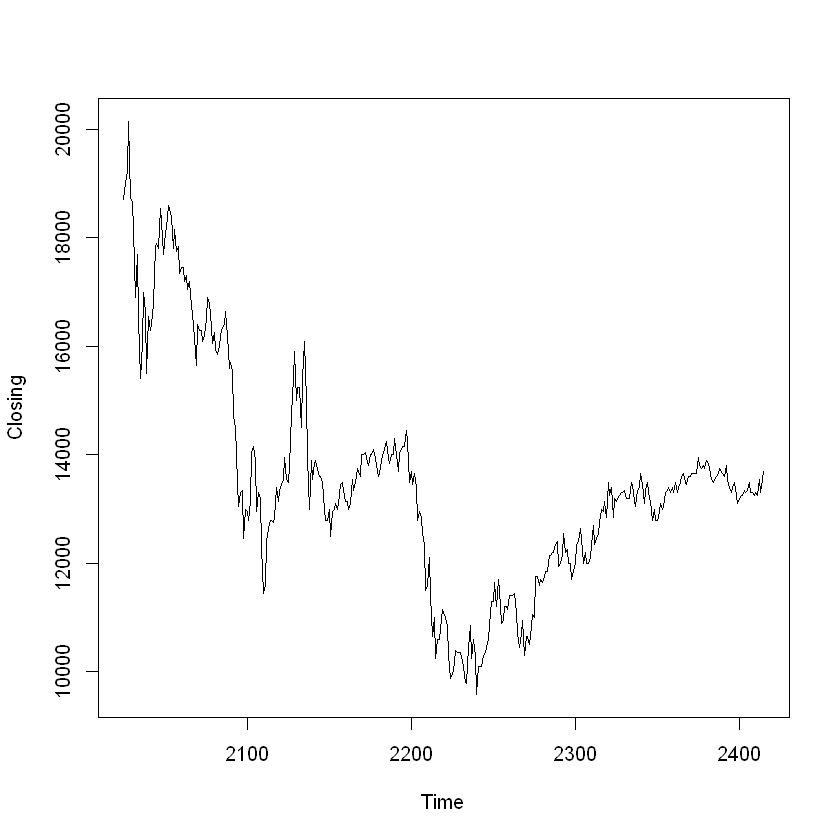

In [12]:
plot.ts(Closing)

In [13]:
ClosingDiff1 <- ts(Closing - Lag(Closing, 1), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingDiff1_train <- ClosingDiff1[1:381]
ClosingDiff1_test <- ClosingDiff1[382:391]

In [14]:
head(ClosingDiff1, 5)

A Time Series:
[1]    NA   300   250   900 -1400

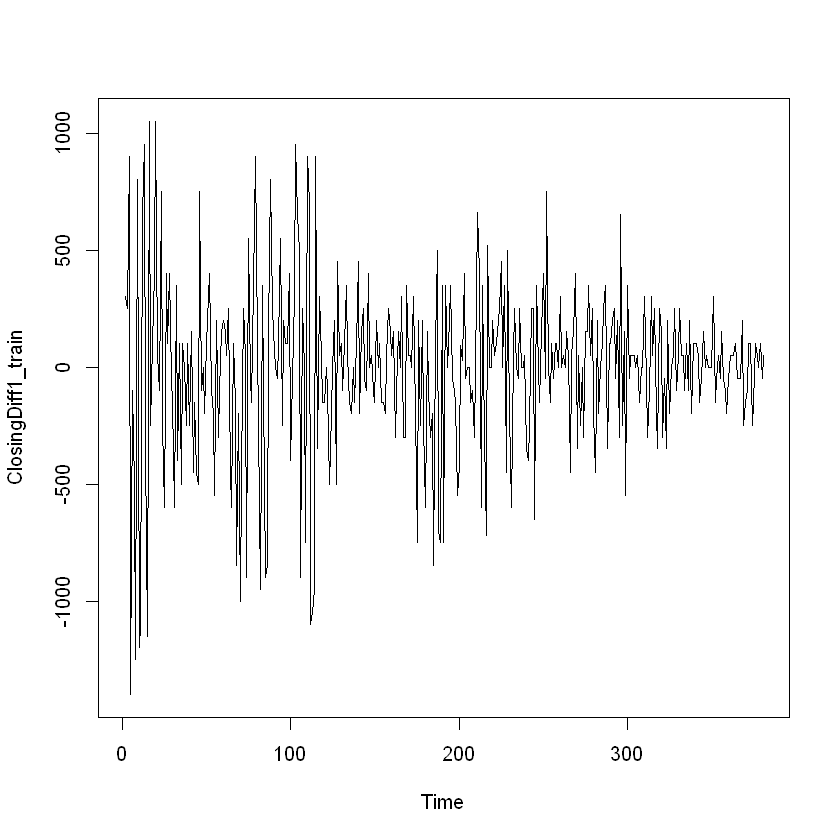

In [15]:
plot.ts(ClosingDiff1_train)

In [16]:
ClosingRelativeDiff <- ts((Closing - Lag(Closing,1))/Lag(Closing,1), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingRelativeDiff_train <- ClosingRelativeDiff[1:381]
ClosingRelativeDiff_test <- ClosingRelativeDiff[382:391]

In [17]:
head(ClosingRelativeDiff, 5)

A Time Series:
[1]          NA  0.01604278  0.01315789  0.04675325 -0.06947891

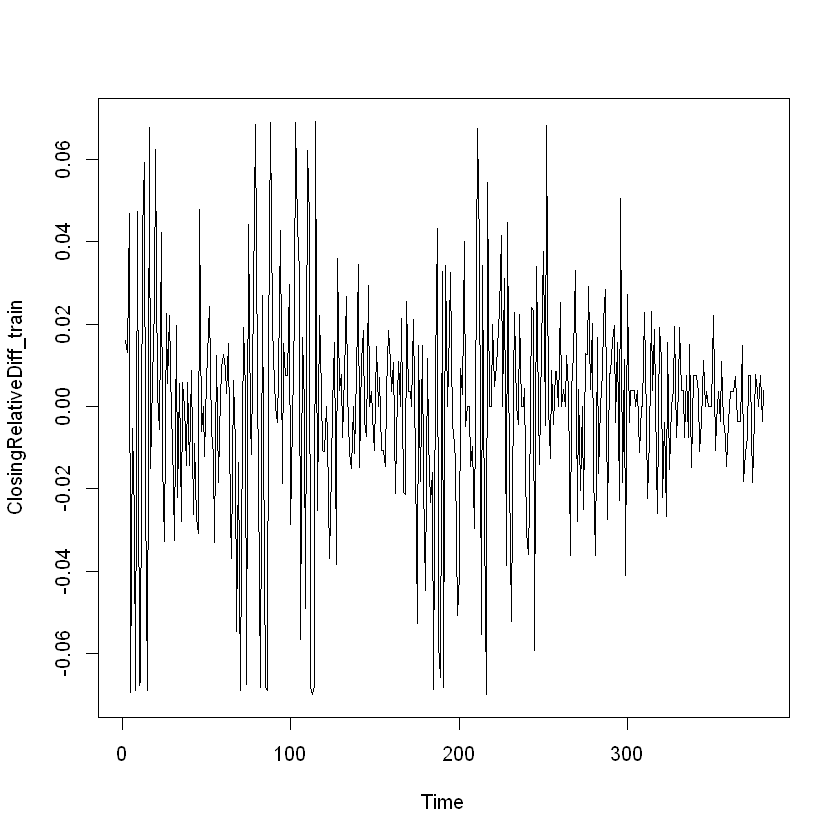

In [18]:
plot.ts(ClosingRelativeDiff_train)

In [19]:
ClosingLR <- ts(log(Closing/Lag(Closing, 1)), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingLR_train <- ClosingLR[1:381]
ClosingLR_test <- ClosingLR[382:391]

In [20]:
head(ClosingLR, 5)

A Time Series:
[1]          NA  0.01591546  0.01307208  0.04569323 -0.07201054

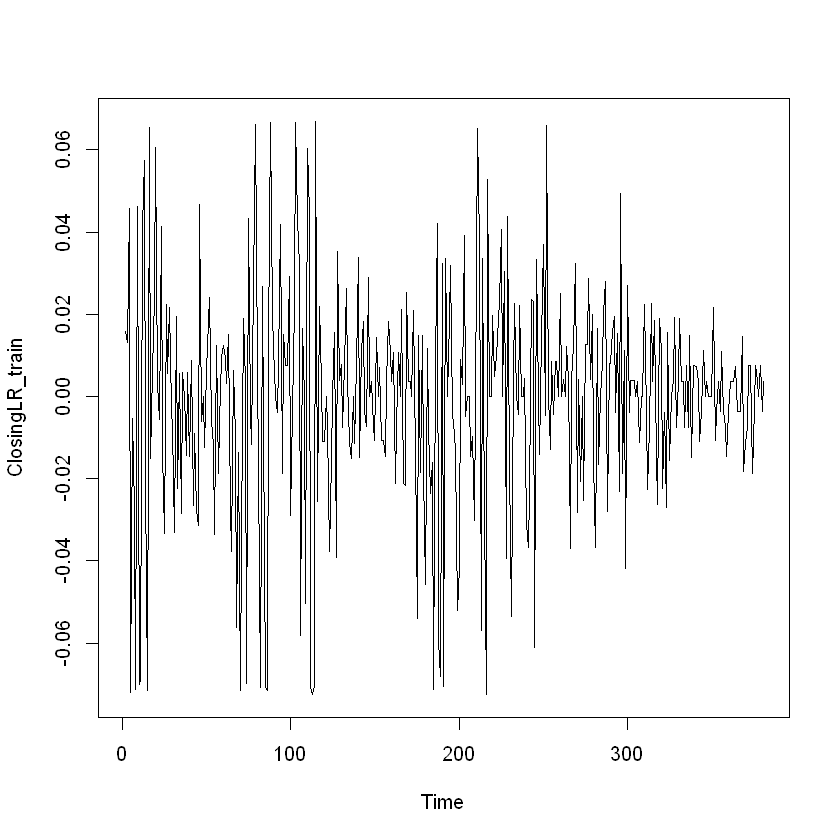

In [21]:
plot.ts(ClosingLR_train)

DF tests: Checking for stationary series

original series is not stationary


In [22]:
summary(ur.df(ClosingDiff1_train[2:381], type = "drift", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1295.09  -151.83    33.25   190.01  1105.48 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
(Intercept) -18.18706   19.13060  -0.951              0.3424    
z.lag.1      -1.17794    0.07451 -15.810 <0.0000000000000002 ***
z.diff.lag    0.11295    0.05122   2.205              0.0281 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 371.3 on 375 degrees of freedom
Multiple R-squared:  0.5356,	Adjusted R-squared:  0.5331 
F-statistic: 216.3 on 2 and 375 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.8098 124.9763 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.

In [23]:
summary(ur.df(ClosingDiff1_train[2:381], type = "none", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1315.63  -169.62    15.01   172.14  1086.26 

Coefficients:
           Estimate Std. Error t value            Pr(>|t|)    
z.lag.1    -1.17390    0.07438 -15.783 <0.0000000000000002 ***
z.diff.lag  0.11099    0.05118   2.169              0.0307 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 371.3 on 376 degrees of freedom
Multiple R-squared:  0.5345,	Adjusted R-squared:  0.532 
F-statistic: 215.9 on 2 and 376 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.7833 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingDiff1 is stationary (None)

In [24]:
summary(ur.df(ClosingRelativeDiff_train[2:381], type = "drift", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.079808 -0.011660  0.001859  0.013579  0.072894 

Coefficients:
              Estimate Std. Error t value            Pr(>|t|)    
(Intercept) -0.0007026  0.0013763  -0.510              0.6100    
z.lag.1     -1.1800339  0.0745707 -15.824 <0.0000000000000002 ***
z.diff.lag   0.1146383  0.0512551   2.237              0.0259 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02675 on 375 degrees of freedom
Multiple R-squared:  0.5357,	Adjusted R-squared:  0.5333 
F-statistic: 216.4 on 2 and 375 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.8244 125.2058 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.8

In [25]:
summary(ur.df(ClosingRelativeDiff_train[2:381], type = "none", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.080432 -0.012368  0.001157  0.012855  0.072174 

Coefficients:
           Estimate Std. Error t value            Pr(>|t|)    
z.lag.1    -1.17889    0.07446 -15.832 <0.0000000000000002 ***
z.diff.lag  0.11409    0.05119   2.229              0.0264 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02672 on 376 degrees of freedom
Multiple R-squared:  0.5354,	Adjusted R-squared:  0.5329 
F-statistic: 216.7 on 2 and 376 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.8317 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingRelativeDiff is stationary (None)

In [26]:
summary(ur.df(ClosingLR_train[2:381], type = 'drift', selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.081730 -0.011543  0.002239  0.013757  0.070903 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
(Intercept) -0.001125   0.001387  -0.812              0.4175    
z.lag.1     -1.172597   0.074480 -15.744 <0.0000000000000002 ***
z.diff.lag   0.111160   0.051275   2.168              0.0308 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02692 on 375 degrees of freedom
Multiple R-squared:  0.5337,	Adjusted R-squared:  0.5312 
F-statistic: 214.6 on 2 and 375 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.7438 123.9338 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2

In [27]:
summary(ur.df(ClosingLR_train[2:381], type = 'none', selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.082642 -0.012787  0.001146  0.012647  0.069731 

Coefficients:
           Estimate Std. Error t value            Pr(>|t|)    
z.lag.1    -1.16962    0.07436 -15.730 <0.0000000000000002 ***
z.diff.lag  0.10971    0.05122   2.142              0.0328 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02691 on 376 degrees of freedom
Multiple R-squared:  0.5329,	Adjusted R-squared:  0.5304 
F-statistic: 214.5 on 2 and 376 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -15.73 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingLR is stationary

Checking for ACF, PACF to apply to ARMA models for ClosingDiff1, ClosingRelativeDiff and ClosingLR

In [28]:
qnorm(1-0.05/2)/sqrt(length(ClosingDiff1_train))

[1] 0.100412

ClosingDiff1 


Autocorrelations of series 'ClosingDiff1_train[2:381]', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.057 -0.109  0.053  0.023 -0.020 -0.004  0.029 -0.038 -0.029  0.031 
    11     12     13     14     15     16     17     18     19     20     21 
-0.017 -0.058 -0.037  0.092 -0.028  0.039  0.016 -0.050 -0.047 -0.051 -0.036 
    22     23     24     25 
-0.069  0.021 -0.009  0.038 


Partial autocorrelations of series 'ClosingDiff1_train[2:381]', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.057 -0.113  0.040  0.017 -0.007 -0.003  0.024 -0.035 -0.027  0.018 -0.018 
    12     13     14     15     16     17     18     19     20     21     22 
-0.051 -0.050  0.077 -0.020  0.062  0.006 -0.040 -0.052 -0.075 -0.060 -0.079 
    23     24     25 
 0.010 -0.024  0.055 

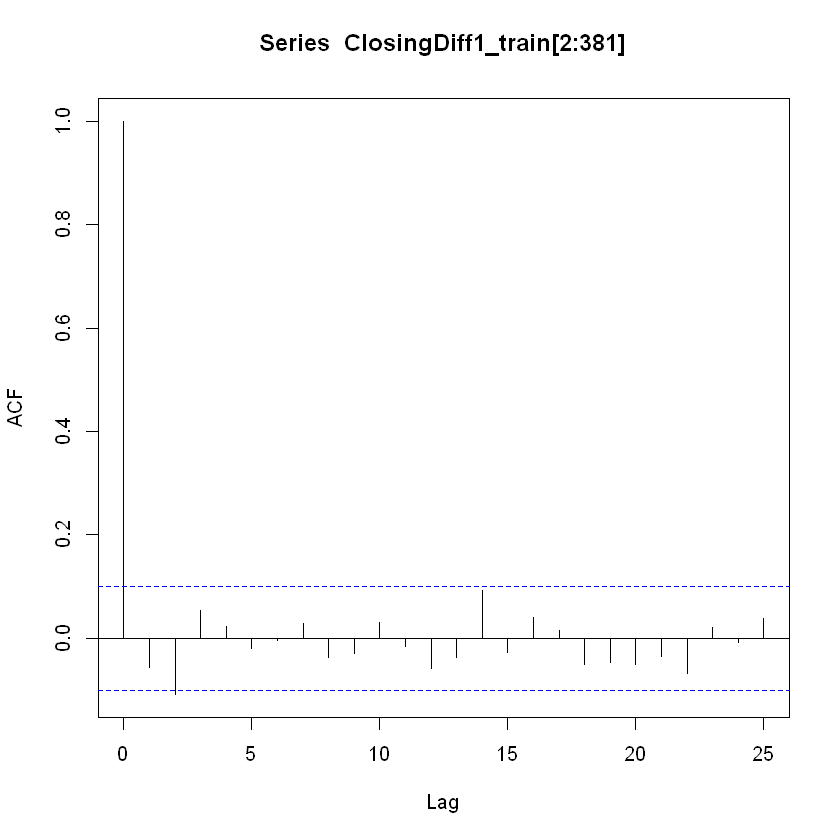

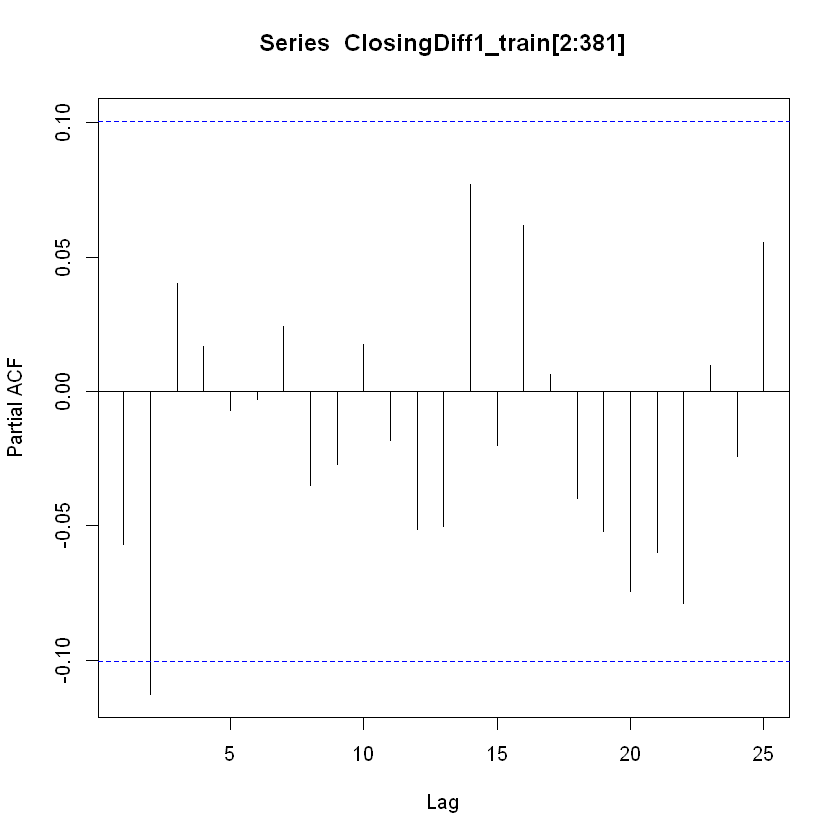

In [29]:
#ARMA(-2,-2)
acf(ClosingDiff1_train[2:381], plot = FALSE)
pacf(ClosingDiff1_train[2:381], plot = FALSE)
acf(ClosingDiff1_train[2:381])
pacf(ClosingDiff1_train[2:381])

ClosingRelativeDiff 


Autocorrelations of series 'ClosingRelativeDiff_train[2:381]', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.058 -0.111  0.043  0.005 -0.029  0.007  0.000  0.004 -0.003  0.014 
    11     12     13     14     15     16     17     18     19     20     21 
 0.008 -0.062 -0.031  0.089 -0.002  0.050  0.015 -0.041 -0.042 -0.096 -0.028 
    22     23     24     25 
-0.051  0.001 -0.008  0.052 


Partial autocorrelations of series 'ClosingRelativeDiff_train[2:381]', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.058 -0.115  0.030 -0.003 -0.021  0.002 -0.005  0.006 -0.003  0.015  0.009 
    12     13     14     15     16     17     18     19     20     21     22 
-0.059 -0.038  0.072  0.005  0.072  0.015 -0.028 -0.045 -0.115 -0.047 -0.078 
    23     24     25 
-0.009 -0.027  0.047 

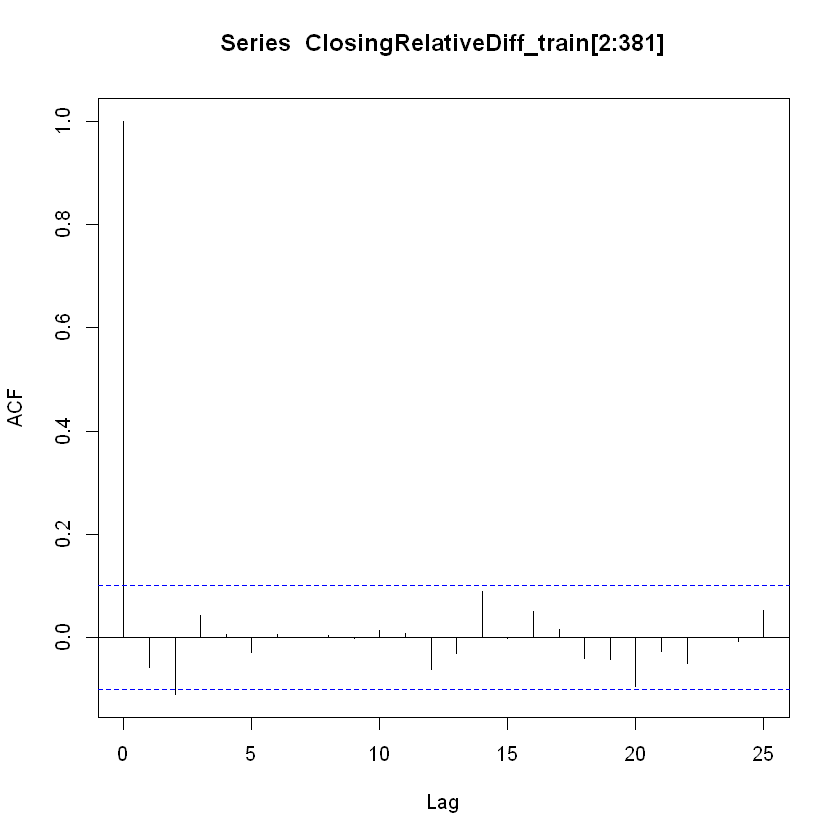

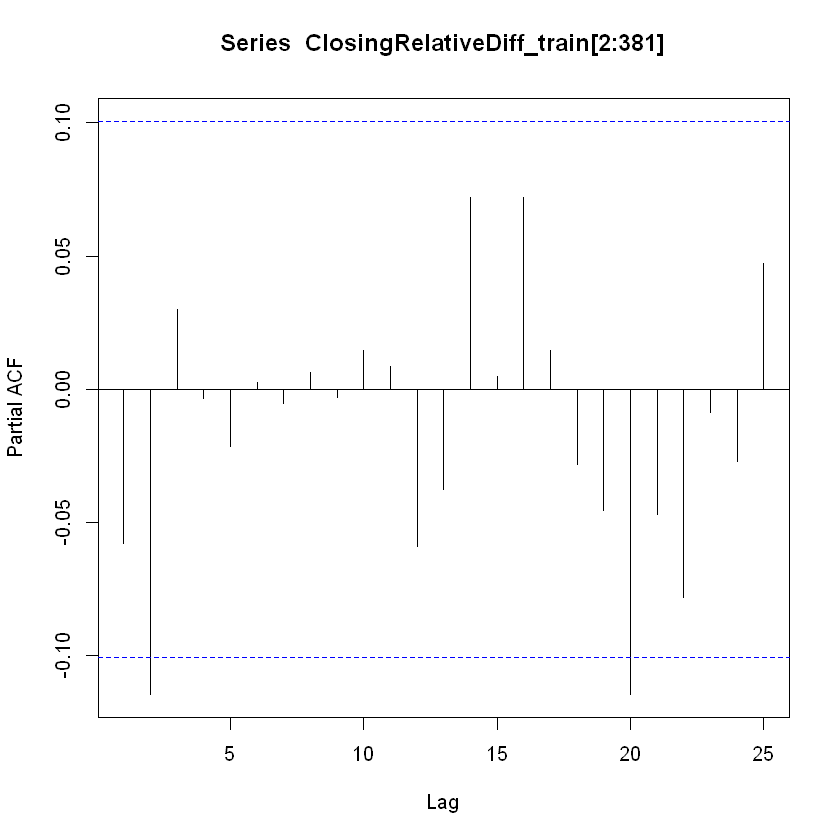

In [30]:
#ARMA(-2,-2)
acf(ClosingRelativeDiff_train[2:381], plot = FALSE)
pacf(ClosingRelativeDiff_train[2:381], plot = FALSE)
acf(ClosingRelativeDiff_train[2:381])
pacf(ClosingRelativeDiff_train[2:381])

ClosingLR 


Autocorrelations of series 'ClosingLR_train[2:381]', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.054 -0.108  0.047  0.005 -0.029  0.008 -0.003  0.002 -0.004  0.015 
    11     12     13     14     15     16     17     18     19     20     21 
 0.008 -0.061 -0.031  0.090 -0.001  0.048  0.015 -0.040 -0.045 -0.094 -0.027 
    22     23     24     25 
-0.051 -0.002 -0.007  0.051 


Partial autocorrelations of series 'ClosingLR_train[2:381]', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.054 -0.111  0.035 -0.002 -0.020  0.004 -0.008  0.005 -0.005  0.015  0.009 
    12     13     14     15     16     17     18     19     20     21     22 
-0.058 -0.038  0.074  0.007  0.070  0.014 -0.029 -0.049 -0.113 -0.045 -0.076 
    23     24     25 
-0.009 -0.025  0.047 

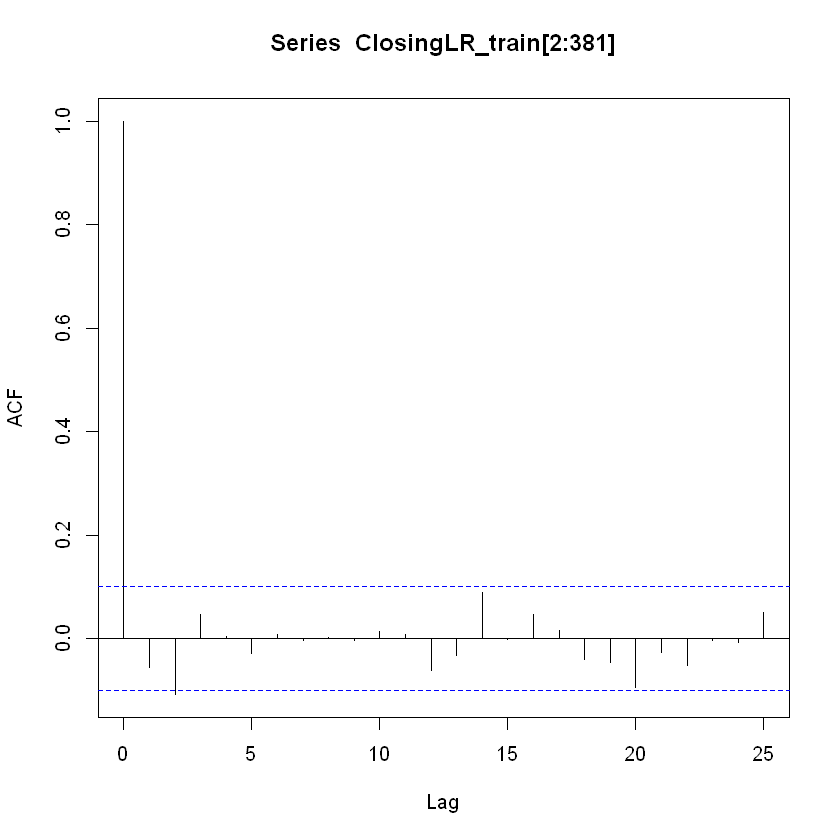

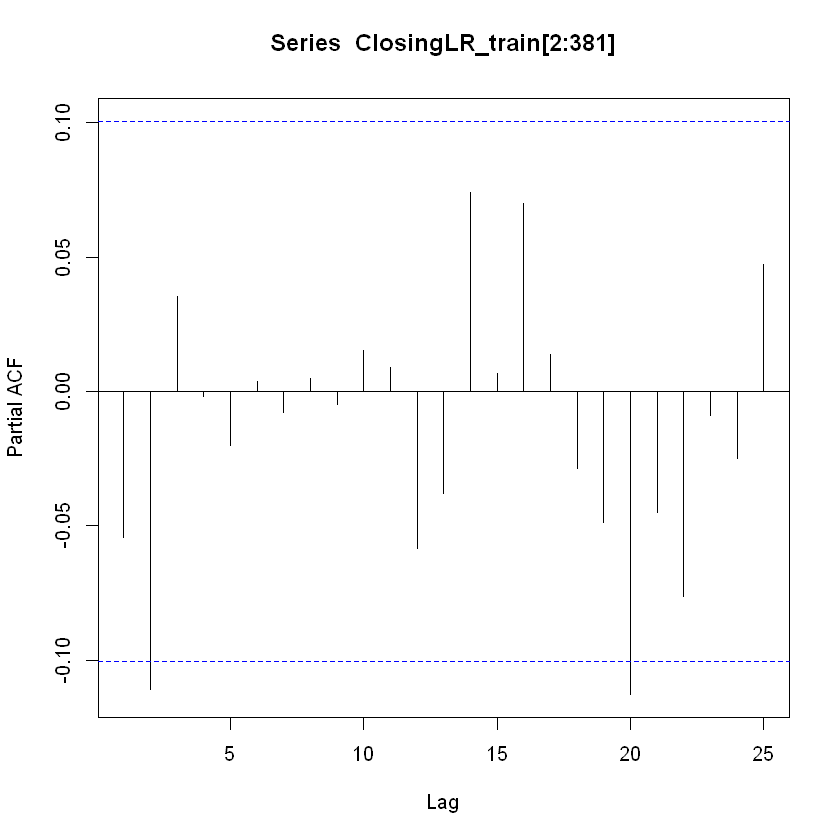

In [31]:
#ARMA(-2,-2)
acf(ClosingLR_train[2:381], plot = FALSE)
pacf(ClosingLR_train[2:381], plot = FALSE)
acf(ClosingLR_train[2:381])
pacf(ClosingLR_train[2:381])

# Fitting ARIMA models

#### ClosingDiff1

In [32]:
summary(arima(ClosingDiff1_train[2:381], order = c(2,0,2)))


Call:
arima(x = ClosingDiff1_train[2:381], order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.3078  -0.4336  0.2502  0.3161   -14.0850
s.e.   0.3644   0.5742  0.3880  0.6038    17.0371

sigma^2 estimated as 136239:  log likelihood = -2785.43,  aic = 5582.85

Training set error measures:
                      ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.00434027 369.1051 262.4535 NaN  Inf 0.6866148 -0.001567769

In [33]:
summary(arma(ClosingDiff1_train[2:381], order = c(2,2)))


Call:
arma(x = ClosingDiff1_train[2:381], order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1531.28  -158.29    44.01   200.29  1183.48 

Coefficient(s):
           Estimate  Std. Error  t value             Pr(>|t|)    
ar1         0.73185     0.08069    9.070 < 0.0000000000000002 ***
ar2        -0.89096     0.15364   -5.799       0.000000006677 ***
ma1        -0.77749     0.06257  -12.426 < 0.0000000000000002 ***
ma2         0.89445     0.14491    6.172       0.000000000673 ***
intercept -26.91123    21.11859   -1.274                0.203    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Fit:
sigma^2 estimated as 136299,  Conditional Sum-of-Squares = 51413558,  AIC = 5580.98


In [34]:
summary(arima(ClosingDiff1_train[2:381], order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingDiff1_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingDiff1_train[2:381], order = c(2, 0, 2), fixed = c(0, NA, 0, 
    NA, NA))

Coefficients:
      ar1      ar2  ma1     ma2  intercept
        0  -0.2084    0  0.1005   -14.2340
s.e.    0   0.4091    0  0.4156    17.3049

sigma^2 estimated as 137083:  log likelihood = -2786.59,  aic = 5581.19

Training set error measures:
                   ME    RMSE     MAE MPE MAPE      MASE       ACF1
Training set 0.158184 370.247 264.192 NaN  Inf 0.6911628 -0.0590403

#### ClosingRelativeDiff

In [35]:
summary(arma(ClosingRelativeDiff_train[2:381], order = c(2,2)))


Call:
arma(x = ClosingRelativeDiff_train[2:381], order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.080715 -0.011662  0.002094  0.013569  0.072847 

Coefficient(s):
            Estimate  Std. Error  t value Pr(>|t|)
ar1       -0.0737757   0.4071997   -0.181    0.856
ar2       -0.2018662   0.3545288   -0.569    0.569
ma1        0.0066240   0.4156528    0.016    0.987
ma2        0.0894892   0.3737740    0.239    0.811
intercept -0.0007545   0.0015150   -0.498    0.618

Fit:
sigma^2 estimated as 0.0007114,  Conditional Sum-of-Squares = 0.27,  AIC = -1665.95


In [36]:
summary(arima(ClosingRelativeDiff_train[2:381], order = c(2,0,2)))


Call:
arima(x = ClosingRelativeDiff_train[2:381], order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.2995  -0.2154  0.2389  0.0897    -0.0005
s.e.   0.3947   0.4136  0.4029  0.4217     0.0012

sigma^2 estimated as 0.0007065:  log likelihood = 839.27,  aic = -1666.54

Training set error measures:
                         ME       RMSE        MAE MPE MAPE      MASE
Training set 0.000005287506 0.02658011 0.01922893 NaN  Inf 0.6823235
                      ACF1
Training set -0.0003239604

In [37]:
summary(arima(ClosingRelativeDiff_train[2:381], order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingRelativeDiff_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingRelativeDiff_train[2:381], order = c(2, 0, 2), fixed = c(0, 
    NA, 0, NA, NA))

Coefficients:
      ar1      ar2  ma1      ma2  intercept
        0  -0.0650    0  -0.0461    -0.0005
s.e.    0   0.4361    0   0.4371     0.0012

sigma^2 estimated as 0.0007101:  log likelihood = 838.3,  aic = -1668.6

Training set error measures:
                         ME       RMSE        MAE MPE MAPE      MASE
Training set 0.000002685006 0.02664853 0.01935687 NaN  Inf 0.6868633
                    ACF1
Training set -0.06093677

#### ClosingLR

In [38]:
summary(arima(ClosingLR_train[2:381], order = c(2,0,2)))


Call:
arima(x = ClosingLR_train[2:381], order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.3416  -0.2667  0.2856  0.1442    -0.0009
s.e.   0.3967   0.4031  0.4075  0.4145     0.0012

sigma^2 estimated as 0.0007157:  log likelihood = 836.82,  aic = -1661.64

Training set error measures:
                         ME       RMSE        MAE MPE MAPE      MASE
Training set 0.000001523173 0.02675215 0.01934247 NaN  Inf 0.6848024
                      ACF1
Training set -0.0005118684

In [39]:
summary(arima(ClosingLR_train[2:381], order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingLR_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingLR_train[2:381], order = c(2, 0, 2), fixed = c(0, NA, 0, NA, 
    NA))

Coefficients:
      ar1      ar2  ma1      ma2  intercept
        0  -0.0548    0  -0.0533    -0.0009
s.e.    0   0.4443    0   0.4440     0.0012

sigma^2 estimated as 0.0007193:  log likelihood = 835.86,  aic = -1663.72

Training set error measures:
                         ME       RMSE        MAE MPE MAPE     MASE        ACF1
Training set 0.000006997088 0.02682007 0.01945761 NaN  Inf 0.688879 -0.05645572

In [40]:
summary(arma(ClosingLR_train[2:381], order = c(2,2)))


Call:
arma(x = ClosingLR_train[2:381], order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.083024 -0.011477  0.002463  0.013930  0.070822 

Coefficient(s):
           Estimate  Std. Error  t value Pr(>|t|)
ar1       -0.097845    0.404949   -0.242    0.809
ar2       -0.227152    0.355226   -0.639    0.523
ma1        0.034121    0.413979    0.082    0.934
ma2        0.116888    0.373021    0.313    0.754
intercept -0.001258    0.001637   -0.769    0.442

Fit:
sigma^2 estimated as 0.0007208,  Conditional Sum-of-Squares = 0.27,  AIC = -1660.95


## Forecasting

##### Export fitted/forecast values and actual values

Model 1

In [41]:
fitted_1 <- append(arma(ClosingDiff1_train[2:381], order = c(2,2))$fitted, NA, after = 1)
resid_1 <- append(arma(ClosingDiff1_train[2:381], order = c(2,2))$resid, NA, after = 1)

In [42]:
length(fitted_1)

[1] 381

Model 4

In [43]:
fitted_4 <-append(arma(ClosingRelativeDiff_train[2:381], order = c(2,2))$fitted, NA, after = 1)
resid_4 <- append(arma(ClosingRelativeDiff_train[2:381], order = c(2,2))$resid, NA, after = 1)

Model 7

In [44]:
fitted_7 <- append(arma(ClosingLR_train[2:381], order = c(2,2))$fitted, NA, after = 1)
resid_7 <- append(arma(ClosingLR_train[2:381], order = c(2,2))$resid, NA, after = 1)

In [45]:
length(arma(ClosingLR_train[2:381], order = c(2,2))$resid)

[1] 380

In [46]:
fitted_2 <- c(rep("-", 381))
fitted_3 <- c(rep("-", 381))
fitted_5 <- c(rep("-", 381))
fitted_6 <- c(rep("-", 381))
fitted_8 <- c(rep("-", 381))
fitted_9 <- c(rep("-", 381))

In [47]:
results <- as.data.frame(cbind(Closing[1:381],ClosingDiff1_train, fitted_1, resid_1, fitted_2, fitted_3, ClosingRelativeDiff_train, fitted_4, resid_4,fitted_5,fitted_6, ClosingLR_train, fitted_7, resid_7),fitted_8, fitted_9)

In [48]:
colnames(results)[1] = 'Price'

In [49]:
write.csv(results, "D:\\results.csv", row.names = FALSE)

In [50]:
forecast(arima(ClosingDiff1_train[2:381], order = c(2,0,2)), h=35)

    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
381      -10.93844 -483.9657 462.0888 -734.3711 712.4943
382      -18.93208 -492.7419 454.8778 -743.5617 705.6976
383      -13.95741 -490.1128 462.1979 -742.1742 714.2593
384      -12.02280 -488.9056 464.8600 -741.3520 717.3064
385      -14.77499 -491.8179 462.2680 -744.3492 714.7992
386      -14.76671 -492.0524 462.5190 -744.7122 715.1787
387      -13.57604 -490.8622 463.7101 -743.5222 716.3701
388      -13.94608 -491.2808 463.3886 -743.9665 716.0743
389      -14.34841 -491.6865 462.9897 -744.3740 715.6772
390      -14.06415 -491.4082 463.2799 -744.0989 715.9706
391      -13.97721 -491.3237 463.3693 -744.0157 716.0613
392      -14.12721 -491.4741 463.2196 -744.1662 715.9118
393      -14.11874 -491.4663 463.2288 -744.1589 715.9214
394      -14.05631 -491.4039 463.2913 -744.0964 715.9838
395      -14.07920 -491.4269 463.2685 -744.1195 715.9611
396      -14.09922 -491.4469 463.2485 -744.1396 715.9411
397      -14.08313 -491.4309 46

In [51]:
forecast(arima(ClosingDiff1_train[2:381], order = c(2,0,2), fixed = c(0,NA,0,NA,NA)), h=35)

Warning message in arima(ClosingDiff1_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"


    Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
381      -10.37228 -484.8629 464.1184 -736.0431 715.2986
382      -20.01181 -494.5025 454.4788 -745.6827 705.6590
383      -15.03892 -492.2837 462.2059 -744.9218 714.8440
384      -13.02961 -490.2744 464.2152 -742.9125 716.8533
385      -14.06618 -491.4303 463.2979 -744.1316 715.9992
386      -14.48501 -491.8491 462.8791 -744.5504 715.5804
387      -14.26894 -491.6382 463.1003 -744.3422 715.8044
388      -14.18164 -491.5509 463.1876 -744.2549 715.8917
389      -14.22668 -491.5962 463.1428 -744.3003 715.8470
390      -14.24488 -491.6144 463.1246 -744.3185 715.8288
391      -14.23549 -491.6050 463.1340 -744.3091 715.8382
392      -14.23169 -491.6012 463.1378 -744.3054 715.8420
393      -14.23365 -491.6032 463.1359 -744.3073 715.8400
394      -14.23444 -491.6039 463.1351 -744.3081 715.8392
395      -14.23403 -491.6035 463.1355 -744.3077 715.8396
396      -14.23387 -491.6034 463.1356 -744.3075 715.8398
397      -14.23395 -491.6035 46

In [52]:
forecast(arima(ClosingRelativeDiff_train[2:381], order = c(2,0,2)), h=35)

    Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
381  -0.0001823481 -0.03424613 0.03388143 -0.05227840 0.05191370
382  -0.0011084879 -0.03523483 0.03301785 -0.05330022 0.05108324
383  -0.0004310422 -0.03475323 0.03389114 -0.05292229 0.05206021
384  -0.0004344946 -0.03479128 0.03392229 -0.05297866 0.05210967
385  -0.0005793583 -0.03493769 0.03377898 -0.05312590 0.05196718
386  -0.0005352249 -0.03489625 0.03382580 -0.05308588 0.05201543
387  -0.0005172453 -0.03487832 0.03384383 -0.05306797 0.05203348
388  -0.0005321354 -0.03489329 0.03382902 -0.05308299 0.05201872
389  -0.0005315476 -0.03489272 0.03382963 -0.05308243 0.05201933
390  -0.0005285169 -0.03488969 0.03383266 -0.05307940 0.05202236
391  -0.0005295512 -0.03489073 0.03383162 -0.05308043 0.05202133
392  -0.0005298941 -0.03489107 0.03383128 -0.05308078 0.05202099
393  -0.0005295687 -0.03489074 0.03383161 -0.05308045 0.05202131
394  -0.0005295923 -0.03489077 0.03383158 -0.05308048 0.05202129
395  -0.0005296553 -0.034

In [53]:
forecast(arima(ClosingRelativeDiff_train[2:381], order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)), h=35)

Warning message in arima(ClosingRelativeDiff_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"


    Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
381  -0.0001743378 -0.03432580 0.03397713 -0.05240450 0.05205582
382  -0.0010462416 -0.03519771 0.03310522 -0.05327640 0.05118392
383  -0.0005504917 -0.03491223 0.03381124 -0.05310223 0.05200125
384  -0.0004937850 -0.03485552 0.03386795 -0.05304552 0.05205795
385  -0.0005260275 -0.03488865 0.03383659 -0.05307912 0.05202707
386  -0.0005297155 -0.03489234 0.03383291 -0.05308281 0.05202338
387  -0.0005276186 -0.03489024 0.03383501 -0.05308072 0.05202548
388  -0.0005273787 -0.03489000 0.03383525 -0.05308048 0.05202572
389  -0.0005275151 -0.03489014 0.03383511 -0.05308061 0.05202558
390  -0.0005275307 -0.03489016 0.03383509 -0.05308063 0.05202557
391  -0.0005275218 -0.03489015 0.03383510 -0.05308062 0.05202558
392  -0.0005275208 -0.03489015 0.03383510 -0.05308062 0.05202558
393  -0.0005275214 -0.03489015 0.03383510 -0.05308062 0.05202558
394  -0.0005275214 -0.03489015 0.03383510 -0.05308062 0.05202558
395  -0.0005275214 -0.034

In [54]:
(arima(ClosingLR_train[2:381], order = c(2,0,2))$resid)

A Time Series:
  [1]  0.01666517133  0.01476921510  0.04922421999 -0.06767806561 -0.00409042024
  [6] -0.03585209143 -0.06980544393  0.04116759341 -0.07370213327 -0.06409122322
 [11]  0.02941457860  0.05549336363 -0.00879776715 -0.06739797294  0.05750082644
 [16] -0.01719760152  0.01644986284  0.02133757296  0.06344979223  0.01016114384
 [21]  0.00090075382  0.03981091081 -0.01103761329 -0.02812160756  0.01839523281
 [26]  0.00448172021  0.02707921014 -0.00074809007 -0.00550157400 -0.03353453032
 [31]  0.01778436226 -0.02329097937  0.00871751252 -0.03013792185  0.00632226740
 [36] -0.00164522045 -0.01190953634  0.00593673035 -0.01497384270  0.01018396358
 [41] -0.02672187022 -0.00812091722 -0.03002387364 -0.03205915187  0.04365436506
 [46] -0.00493212342  0.00693957161 -0.01381863002  0.00635107162  0.01877931966
 [51]  0.02702196195 -0.00185581373 -0.00955139209 -0.03494205422  0.01046857665
 [56] -0.01991293216 -0.00374323970  0.00767104094  0.01374059257  0.01237067377
 [61]  0.00542956319  0.01672496788 -0.02554761494 -0.03674864586  0.00180123061
 [66] -0.01126940231 -0.05339921206 -0.01715278751 -0.07710208488 -0.03603740433
 [71]  0.01117773583  0.00462509705 -0.06495625550  0.03970589428 -0.00824907548
 [76] -0.00337664961  0.02555271005  0.06692535303  0.01552813023 -0.01040269585
 [81] -0.07282832556  0.02146509871 -0.01151995343 -0.06445769059 -0.07624126904
 [86]  0.00222222964  0.06382606566  0.02908995374  0.02031055164  0.00078376178
 [91] -0.00249280024  0.00850424171  0.04289541367 -0.01448291838  0.01922125822
 [96]  0.00562316181  0.01103427919  0.03108044502 -0.02621922114 -0.00143750317
[101]  0.01857744105  0.06942629847  0.05064646982  0.04139023803 -0.05354920079
[106]  0.01590533038 -0.00528738484 -0.04537581937  0.05814608005  0.04293391325
[111] -0.05874262809 -0.07286963310 -0.08347914296  0.05927448217 -0.02491346997
[116]  0.03104034510  0.00043729360 -0.00694951792 -0.01036244268 -0.00124901367
[121] -0.00702517995 -0.03664485457 -0.01745389213 -0.00366267831  0.01636149788
[126] -0.03664072060  0.03564196993  0.00200545038  0.01412948773 -0.00691323223
[131]  0.00845614423  0.02695149657  0.00727242307 -0.00740740382 -0.01542468829
[136] -0.00123242514 -0.01149263195  0.00863421959  0.03395232916 -0.01080352529
[141]  0.01472191809  0.01698174055  0.00006078878 -0.00471288428  0.02828050379
[146]  0.00197851015  0.00808301623 -0.00708972748 -0.01001070855  0.01410220625
[151]  0.00087626765  0.01010096926 -0.00984619341 -0.00978026623 -0.01550116541
[156]  0.00306730345  0.01829766185  0.01367237992  0.00694515926  0.01213259069
[161] -0.01975278230 -0.00631736129  0.00872199832  0.00160978513  0.02378735399
[166] -0.01955727937 -0.01966273990  0.02203867818  0.00436137644  0.00848745651
[171]  0.00053289169  0.02197744516 -0.01169628647 -0.05163080462  0.01038478366
[176] -0.02190592681  0.01858144140 -0.01907445029 -0.04398795256  0.00781779295
[181] -0.01045123639 -0.01987605453 -0.01758728720 -0.07377770294  0.00505551264
[186]  0.03676230477 -0.05266853008 -0.06598022617  0.02106664918 -0.07279747391
[191]  0.03726524100 -0.00608397762  0.02544145935  0.03331777202 -0.00037078367
[196] -0.00534731021 -0.01500966478 -0.05263679119 -0.04443346798  0.00268449078
[201]  0.00206800100  0.04311730527 -0.00180586338  0.00454276739 -0.00089302427
[206] -0.01356916816 -0.00940464501 -0.03133954992 -0.00221068050  0.06342950872
[211]  0.04320556224 -0.04671402341  0.03270668994 -0.03359091297 -0.06700922328
[216]  0.04586146072 -0.00328096772  0.00985176407  0.01869700677  0.00620879831
[221]  0.01345952409  0.01551771133  0.02580009704  0.04422378269  0.00517542635
[226]  0.03491658611 -0.03826349986  0.04567980640 -0.01893117995 -0.04757445054
[231] -0.00057649882  0.01830007864  0.00521690113 -0.00115276440  0.02165216438
[236]  0.00179172001  0.00370975969  0.00448791586 -0.02993704265 -0.03680450080
[241] -0.02819891529  0.02056884411  0.02448586820 -0.05553156358  0.03243405878
[246] -0.0047353

In [55]:
forecast(arima(ClosingLR_train[2:381], order = c(2,0,2)), h = 35)

    Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
381  -0.0005357166 -0.03481998 0.03374854 -0.05296897 0.05189754
382  -0.0014676629 -0.03580551 0.03287019 -0.05398287 0.05104755
383  -0.0007853564 -0.03530577 0.03373505 -0.05357977 0.05200905
384  -0.0007698579 -0.03533322 0.03379350 -0.05362995 0.05209024
385  -0.0009571298 -0.03552234 0.03360808 -0.05382005 0.05190579
386  -0.0008972955 -0.03546739 0.03367280 -0.05376769 0.05197310
387  -0.0008677863 -0.03543804 0.03370246 -0.05373842 0.05200285
388  -0.0008938244 -0.03546428 0.03367663 -0.05376478 0.05197713
389  -0.0008928007 -0.03546333 0.03367772 -0.05376386 0.05197826
390  -0.0008862058 -0.03545673 0.03368432 -0.05375726 0.05198485
391  -0.0008887315 -0.03545926 0.03368180 -0.05375980 0.05198234
392  -0.0008896277 -0.03546016 0.03368091 -0.05376070 0.05198144
393  -0.0008886479 -0.03545918 0.03368189 -0.05375972 0.05198242
394  -0.0008887436 -0.03545928 0.03368179 -0.05375981 0.05198232
395  -0.0008889722 -0.035

In [56]:
forecast(arima(ClosingLR_train[2:381], order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)), h = 35)

Warning message in arima(ClosingLR_train[2:381], order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"


    Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
381  -0.0005927503 -0.03496406 0.03377856 -0.05315913 0.05197363
382  -0.0014462783 -0.03581758 0.03292503 -0.05401265 0.05112010
383  -0.0009107555 -0.03548230 0.03366079 -0.05378338 0.05196186
384  -0.0008639839 -0.03543553 0.03370756 -0.05373660 0.05200864
385  -0.0008933295 -0.03546548 0.03367882 -0.05376687 0.05198021
386  -0.0008958925 -0.03546804 0.03367626 -0.05376943 0.05197764
387  -0.0008942844 -0.03546643 0.03367787 -0.05376782 0.05197926
388  -0.0008941439 -0.03546629 0.03367801 -0.05376768 0.05197940
389  -0.0008942321 -0.03546638 0.03367792 -0.05376777 0.05197931
390  -0.0008942398 -0.03546639 0.03367791 -0.05376778 0.05197930
391  -0.0008942349 -0.03546638 0.03367791 -0.05376777 0.05197931
392  -0.0008942345 -0.03546638 0.03367792 -0.05376777 0.05197931
393  -0.0008942348 -0.03546638 0.03367791 -0.05376777 0.05197931
394  -0.0008942348 -0.03546638 0.03367791 -0.05376777 0.05197931
395  -0.0008942348 -0.035